# Part 3

### About this Notebook
This notebook goes through my thought process in the modeling. A less-technical, more business-oriented summary will 
appear at the end, and an appendix has more detail.  Commentary is provided via text cells like this, with headings the 
same size as "About this Notebook" above.

### Imports

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
import tempfile
import time
plt.style.use('seaborn')

In [2]:
with open('../../data/raw/ultimate_data_challenge.json') as file0:
    text = file0.read().replace('NaN', '"NaN"')
    with open('../../data/raw/uber_no_probs.json', 'w') as new_file:
        new_file.write(text)

In [3]:
df_raw = pd.read_json('../../data/raw/uber_no_probs.json', orient='records')
df = df_raw.copy()
df2 = df_raw.copy()
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


### Basic Visualizations
Basic Visualizations included:
1. df.info(), df.describe(), df.head() for quick overview of the data set.
2. Single- and multi-variate charts.

A few examples are included below.  More are in the appendix.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


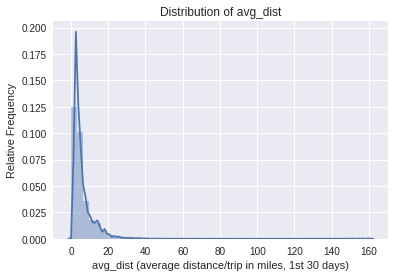

In [5]:
# Single-variable plots for EDA
ax = sns.distplot(df.avg_dist)
ax.set_title('Distribution of avg_dist')
ax.set_xlabel('avg_dist (average distance/trip in miles, 1st 30 days)')
ax.set_ylabel('Relative Frequency');

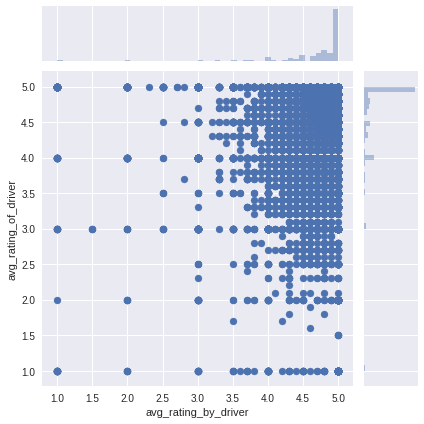

In [6]:
temp = df.copy()
temp = temp[(temp.avg_rating_by_driver.notna()) & (temp.avg_rating_of_driver.notna())]
sns.jointplot(temp.avg_rating_by_driver.dropna(), temp.avg_rating_of_driver.dropna());

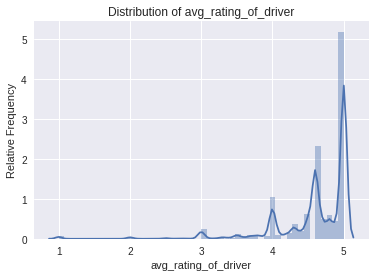

In [7]:
# Pull nans out of rating before graphing
non_nans = df.avg_rating_of_driver.dropna()
mean_nans = df.avg_rating_of_driver.fillna(df.avg_rating_of_driver.mean())
ax = sns.distplot(mean_nans)
ax.set_title('Distribution of avg_rating_of_driver')
ax.set_ylabel('Relative Frequency');

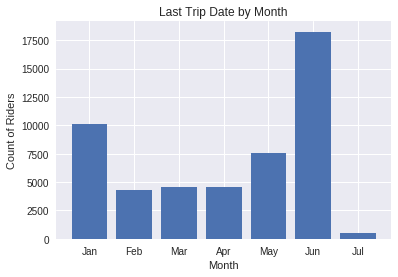

In [8]:
df['last_trip_date'] = pd.to_datetime(df.last_trip_date)
counts = df.last_trip_date.dt.month.value_counts()
fig, ax = plt.subplots()
mpl.axes.Axes.bar(x=counts.index, height=counts.values, ax=ax)
ax.set_title('Last Trip Date by Month')
ax.set_xlabel('Month')
ax.set_xticklabels(['', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul'])
ax.set_ylabel('Count of Riders');

### Further EDA
Further EDA included:
1. Examining the categories with NaNs to understand the best way to deal with Nans
    * For both the "avg_rating" categories, I replaced NaNs with the mean
    * For "phone", I replaced NaN with "NA"
2. Examining categories with outliers
    * I tend to go light with outliers unless I have specific reasons to pull things out
    * In this case, I ran one data set with outliers removed, and one without: not much difference, due to model (Random Forest)
    * Outliers removed included:
        * 41 observations with avg_dist > 50 miles
        * 67 observations with avg_surge > 3
        * 35 observations with trips_in_first_30_days > 40
    * In this case, that's 143 observations, well less than 1% of the data set

In [9]:
# Pull out outliers in df2, leave outliers in df
len(df[df.avg_dist > 50]) # 41
df2 = df2[df2.avg_dist < 50]

In [10]:
# Pull outliers ouf of df2, leave them in df
len(df[df.avg_surge > 3]) # 67
df2 = df2[df2.avg_surge <= 3]

In [11]:
# Pull outliers out of df2, leave them in df
len(df[df.trips_in_first_30_days > 40]) # 35
df2 = df2[df2.trips_in_first_30_days < 40]

### Fill NaNs, change dates to datetime, signup_date to int

In [12]:
df.phone.fillna('NA', inplace=True)
df.avg_rating_by_driver.fillna(df.avg_rating_by_driver.mean(), inplace=True)
df.avg_rating_of_driver.fillna(df.avg_rating_of_driver.mean(), inplace=True)

df['signup_date'] = pd.to_datetime(df.signup_date)
df['last_trip_date'] = pd.to_datetime(df.last_trip_date)

# Signup date is just the date within January they signed up
# Turn it into an int
df['signup_date'] = (pd.to_datetime('2014-02-01') - df['signup_date']).astype(int)

### last_trip_date and our Target
As we're asked to find active riders past 30 days and we have data through July 1, 2014, our target is riders who rode
after June 1, 2014.  Note that our retention rate is 36.62%.

Thus, last_trip_date defines our target. As a result, we'll have to transform it and throw away the detail. Below we'll 
make that transformation.

In [13]:
# Unfortunately we can't keep last_trip_date without snooping
# So let's just turn it into our target variable and drop it
df['retained'] = df.last_trip_date > pd.to_datetime('2014-06-01')
df.drop('last_trip_date', axis='columns', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
phone                     50000 non-null object
signup_date               50000 non-null int64
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
retained                  50000 non-null bool
dtypes: bool(2), float64(6), int64(2), object(2)
memory usage: 3.9+ MB


### One-hot encode the categories

In [14]:
# Categorify and one-hot-encode df.city and df.phone
df['city'] = df.city.astype('category')
df['phone'] = df.phone.astype('category')

data_chunk = pd.get_dummies(df, drop_first=True)
data_chunk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
signup_date               50000 non-null int64
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
retained                  50000 non-null bool
city_King's Landing       50000 non-null uint8
city_Winterfell           50000 non-null uint8
phone_NA                  50000 non-null uint8
phone_iPhone              50000 non-null uint8
dtypes: bool(2), float64(6), int64(2), uint8(4)
memory usage: 3.3 MB


### Model selection/grid search

A Random Forest is a great fit for our needs here - it's a robust model that doesn't require a lot of tuning, it gives
consistently good results, and it also has a feature_importances_ attribute that will allow us to address the question
about the best predictors for retention.

I tested a few other models against a Random Forest (LinearSVC as suggested by sklearn, and a straight Logistic 
Regression), just to see how they compared. Not surprisingly, the Random Forest did the best (details in the Appendix).

**Notes:**
* I did some feature engineering to see how well I could enhance the results (see Appendix). Although the additional 
features were useful for the non-random forest models, they didn't help the random forest. 
    * This is a known property of random forests; they don't benefit from composed features as much, because they're able 
    to investigate the training space more completely with decision trees.
    * The non-feature-engineered version actually did slightly better (0.75335 AUC vs 0.75332 for engineeered
    features). Because the non-feature-engineered model is also simpler to understand, that's what I'm using.
* Since Random Forests don't require the features to be scaled, and because they're ensemble methods, they're also more resistant to outliers. 
    * The model with all data actually did slightly better in tests (0.75335 AUC vs 0.74860 removing outliers), so that's what I'm using.
* Because Random Forests don't have many useful parameters, running a grid search is typically not that enlightening. At 
the same time, since it's a fast model, there's not much downside to running a grid search.  
    * The grid search showed that setting the max_depth parameter (the maximum depth of an individual decision tree) to 
    10 was better than the default (None), and better than other tested values of 1, 5, and 20.


In [15]:
# Split into X and y

X = data_chunk.drop('retained', axis='columns')
y = data_chunk['retained']

# Do two-level train-test split: first to get the set-aside test set and a train_and_valid set
# Then to split train_and_valid into training and validation sets
X_train_and_valid, X_test, y_train_and_valid, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_and_valid, y_train_and_valid, test_size=0.2, random_state=42)

# Standardize the data set
# Only useful for LinearSVC and Logistic Regression, so it's commented out now
#scaler = StandardScaler()

# model ()
clf = RandomForestClassifier(n_estimators=50, n_jobs=4, random_state=42) 
#clf = LogisticRegression(n_jobs=4, random_state=42) 
#clf = LinearSVC(random_state=42) 

# cache the results in the pipeline
cachedir = tempfile.mkdtemp()

pipeline = Pipeline(memory=cachedir,
                    steps=[#('scaler', scaler), # Scaler is not needed for random forest
                            ('clf', clf)])

# Parameters for grid search
param_grid = {'clf__max_features': ['auto', 'log2', 10],
              'clf__max_depth': [None, 1, 5, 10, 20]}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='roc_auc')

grid.fit(X_train, y_train)

print('Best cv AUC: {:.2f}'.format(grid.best_score_)) # Best cv AUC: 0.85
print('Best validation set score: {:.2f}'.format(grid.score(X_valid, y_valid))) # Best validation set score: 0.85
print('Best parameters: ', grid.best_params_) # Best parameters:  {'clf__max_depth': 10, 'clf__max_features': 'auto'}

Best cv AUC: 0.85
Best validation set score: 0.85
Best parameters:  {'clf__max_depth': 10, 'clf__max_features': 'auto'}


### Train with chosen parameters
With parameters chosen, we'll increase n_estimators (the number of decision trees in our forest) to as many as we can
handle. Then we'll fit against our training set, and predict against our validation set, to get a sense of what to expect
against unseen data.

In [16]:
model = RandomForestClassifier(n_estimators=1000, max_depth=10, n_jobs=4, random_state=42)

model.fit(X_train, y_train)
valid_preds = model.predict(X_valid)

print('Training AUC: {:.2f}'.format(roc_auc_score(y_train, model.predict(X_train))))
print('Validation AUC: {:.2f}'.format(roc_auc_score(y_valid, valid_preds)))

Training AUC: 0.79
Validation AUC: 0.76


### Train and test with chosen parameters
Finally, we can re-train against the entire training + validation set, and predict against our test set.  Since we have
values for our test set, we can also evaluate the model against the test set to get our final evaluation.

Notes:
* Final test AUC = 0.76.  This is the probability that, given two randomly chosen customers (one retained, one not), our
model will rate the retained customer as more likely to be retained than the churned customer (without "looking", of course). For this metric, 1.0 is perfection and 0.5 is guessing.
    * Our model has some predictive value, but we would do better to have more (and more varied) data.
        * For example, more data on the customer's most-recent trip (ratings, surge, weekend, etc.) may be of particular value.
* Overall, our model has a 79% accuracy rate in predicting whether a customer will churn or not.

In [17]:
model = RandomForestClassifier(n_estimators=1000, max_depth=10, n_jobs=4, random_state=42)

model.fit(X_train_and_valid, y_train_and_valid)
test_preds = model.predict(X_test)

print('Training + Validation AUC: {:.2f}'.format(roc_auc_score(y_train_and_valid, model.predict(X_train_and_valid))))
print('Final Test AUC: {:.2f}'.format(roc_auc_score(y_test, test_preds)))
print('Final Test Accuracy: {:.2f}'.format(accuracy_score(y_test, test_preds)))
print('Confusion Matrix:')
print(confusion_matrix(y_test, test_preds))

Training + Validation AUC: 0.79
Final Test AUC: 0.76
Final Test Accuracy: 0.79
Confusion Matrix:
[[5505  817]
 [1279 2399]]


### Feature Importance
Let's look at the most important predictors of customer retention according to our model:
* All the features total up to 100%, so this can be thought of as a pie chart.
* avg_rating_by_driver is the most important, with a relative importance of 18%.
* Whether the rider is from King's Landing is second, with relative importance of 14%.
* The percent of trips taken with surge > 1 is third with relative importance of 13%.

Before we look in detail at the top features, a possibly-surprising result to point out among the "unimportant" features:
* avg_rating_of_driver, the average score that the rider gave to their drivers over all their trips, only has an 
importance of 3%. Certainly "grade inflation" plays a role here, as ratings of 4 and 5 are so common; still, this is
fairly counterintuitive at first glance (again, it would be interesting to see how this compares to the rider's rating of
their *most recent* driver).

In [18]:
# Get feature_importances, match up to data columns, and sort descending
imps = model.feature_importances_

importances = pd.DataFrame(columns=['Feature', 'Importance'],
                           data=(sorted(list(zip(X.columns, imps)), key=lambda tup: tup[1],  reverse=True)))

importances['Importance'] = round(importances.Importance, 2)
importances.set_index('Importance', inplace=True, drop=True)
importances

,Feature
Importance,
0.18,avg_rating_by_driver
0.14,city_King's Landing
0.13,surge_pct
0.12,weekday_pct
0.10,avg_surge
0.08,phone_iPhone
0.07,ultimate_black_user
0.06,trips_in_first_30_days
0.05,avg_dist


### Average Rating by Driver
The average rating by the driver is the most important predictor in our model of whether a customer will churn.  Why is
that? Below we see all the riders with average rating by the driver of 4 or less. On the left are the churned customers;
on the right are the retained customers.

**A customer with an average rating by the driver of 4 or less is 80% likely to churn.**

What does this mean for the business?
* How much of this is cause, and how much of this is effect? Further analysis is warranted.
* We don't have data on the drivers who rated these customers.  Is a subset of drivers more likely to result in churned
customers?
* A couple of options to further investigate and to attempt to reduce churn could include:
    * As a way to test churn-minimization techniques, identify an appropriate avg_rating_by_driver score cohort to focus
    on churn-minimization efforts. Do an A/B test: randomly-chosen members of this group receive no special attention,  
    while the other group receives the churn mitigation efforts (outreach, rebates, or other options). Test, learn, 
    tweak, repeat.
    * An experiment only to be done with much care and thought would be to take a small(!) subset of at-risk customers, 
    record their actual ratings by drivers, and replace the ratings with "inflated" ratings. Test, learn, tweak, repeat.

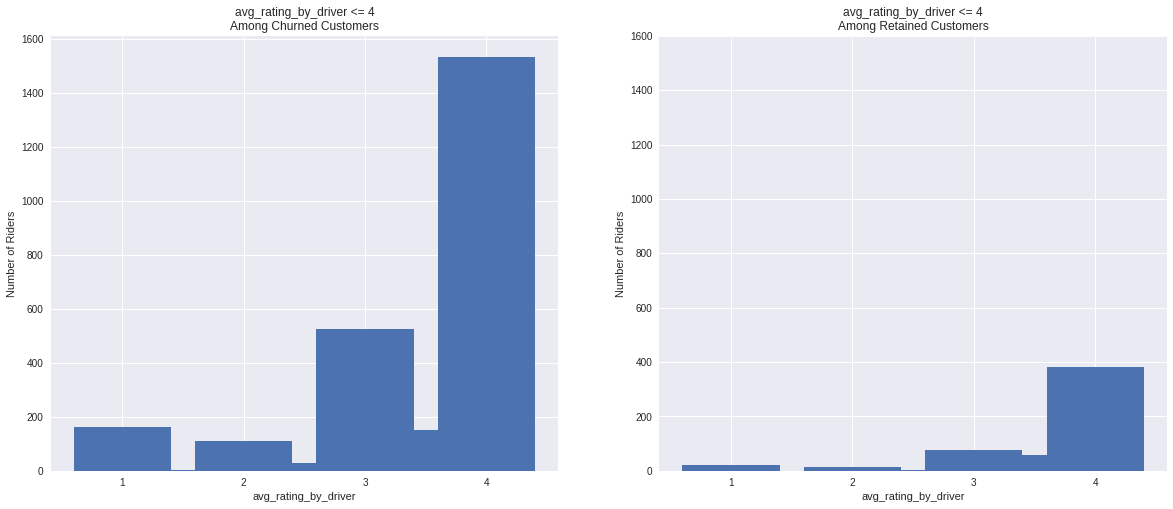

In [19]:
churned = df_raw.loc[(df_raw.last_trip_date <= '2014-06-01') &
                     (df_raw.avg_rating_by_driver <= 4), 'avg_rating_by_driver'].value_counts()
kept = df_raw.loc[(df_raw.last_trip_date > '2014-06-01') &
                  (df_raw.avg_rating_by_driver <= 4), 'avg_rating_by_driver'].value_counts()

# Chart
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(20,8))
ax1.bar(churned.index, churned.values)
ax1.set_title('avg_rating_by_driver <= 4\nAmong Churned Customers')
ax1.set_xlabel('avg_rating_by_driver')
ax1.set_ylabel('Number of Riders')
ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
ax2.bar(kept.index, kept.values)
ax2.set_title('avg_rating_by_driver <= 4\nAmong Retained Customers')
ax2.set_xlabel('avg_rating_by_driver')
ax2.set_ylabel('Number of Riders')
ax2.set_ylim([0, 1600])
ax2.xaxis.set_major_locator(plt.MaxNLocator(5))
plt.tight_layout;

### King's Landing customers
The second most-important feature in our model is whether the customer is from King's Landing. 

Whereas 37% of Uber customers are retained, **62% of customers from King's Landing are retained.**

What does this mean?
* Further research is warranted into why customers from King's Landing churn so much less than others.
* In the meantime, it's worth considering increasing new-customer outreach into King's Landing (advertising, marketing, 
etc.)
* As with the average rating by the driver above, there are many opportunities to do A/B testing.
    * Simple modifications of what's listed above are possible.
    * An interesting data point to dig into would be: are rides to or from, or even just through, King's Landing, more 
    likely to reduce churn?
    * Again, are the drivers in King's Landing more likely to be good drivers?j

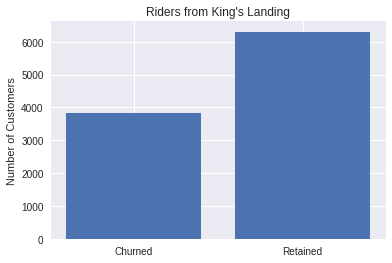

In [20]:
kept_king = len(df_raw[(df_raw.city == "King's Landing") & (df_raw.last_trip_date > '2014-06-01')])
lost_king = len(df_raw[(df_raw.city == "King's Landing") & (df_raw.last_trip_date <= '2014-06-01')])

# Chart
fig, ax = plt.subplots()
mpl.axes.Axes.bar(x=['Churned', 'Retained'], height=[lost_king, kept_king], ax=ax)
ax.set_title("Riders from King's Landing")
ax.set_ylabel('Number of Customers');

### Surge_pct
Similarly surge_pct gives good insight into whether customers churn or not.

**72% of customers who have never ridden during a surge time churn.** Churned customers who never rode during a surge time
represent fully half of our data set, as seen below.

This raises a number of questions:
* Potentially customers who have never ridden during a surge time don't see the full value of the service, or perhaps they 
are particularly price-sensitive.
* Certainly, the most experienced and "professional" drivers must drive during surge times. There may be a customer-
service component to this.

What next?
* Consider rebates and outreach to non-surge customers, giving incentives to find reasons and times to ride during surge
hours.
* Consider testing ways to incentive especially skilled drivers to drive non-surge hours, and measure the results.
* Given the "entertainment" angle present in the logins data, consider building campaigns to push the social aspect of
going out with Uber, to gain and retain more surge-friendly customers.

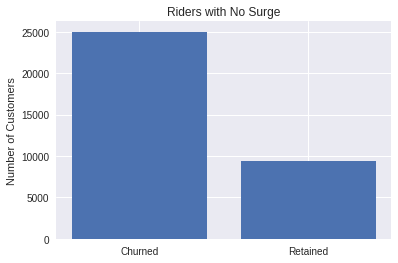

In [21]:
kept_no_surge = len(df_raw[(df_raw.surge_pct == 0) & (df_raw.last_trip_date > '2014-06-01')])
lost_no_surge = len(df_raw[(df_raw.surge_pct == 0) & (df_raw.last_trip_date <= '2014-06-01')])

# Chart
fig, ax = plt.subplots()
mpl.axes.Axes.bar(x=['Churned', 'Retained'], height=[lost_no_surge, kept_no_surge], ax=ax)
ax.set_title("Riders with No Surge")
ax.set_ylabel('Number of Customers');

# Appendix
### Additional Charts

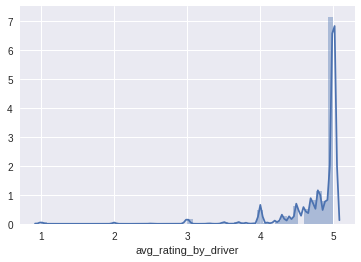

In [10]:
#Pull nans out of rating before graphing
non_nans = df.avg_rating_by_driver.dropna()
sns.distplot(non_nans)
mean_nans = df.avg_rating_by_driver.fillna(df.avg_rating_by_driver.mean())

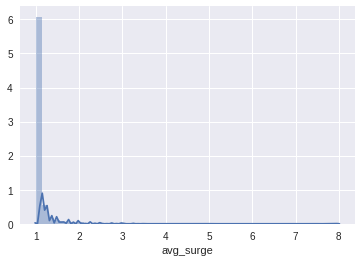

In [12]:
sns.distplot(df.avg_surge)

<BarContainer object of 3 artists>

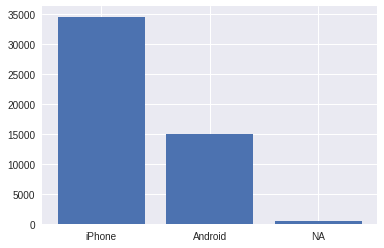

In [17]:
counts = df.phone.fillna('NA').value_counts()
plt.bar(counts.index, counts.values)

<BarContainer object of 5 artists>

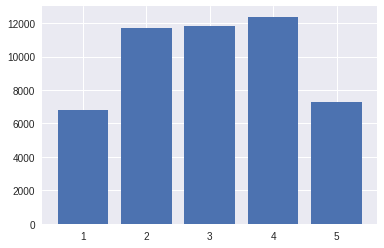

In [18]:
# df.signup_date.nunique() # 31
df['signup_date'] = pd.to_datetime(df.signup_date)
counts = df.signup_date.dt.week.value_counts()
plt.bar(counts.index, counts.values)

<BarContainer object of 10 artists>

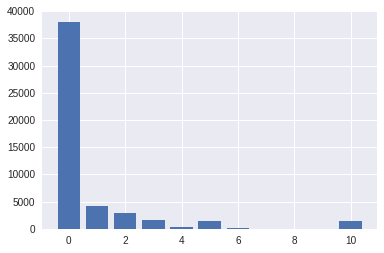

In [19]:
counts = (df.surge_pct // 10).value_counts()
plt.bar(counts.index, counts.values)

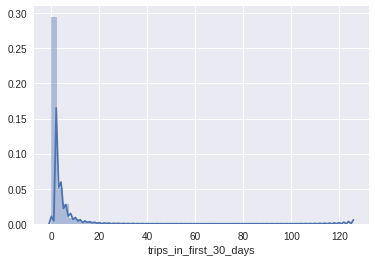

In [20]:
sns.distplot(df.trips_in_first_30_days)

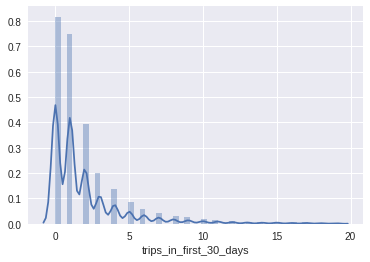

In [23]:
# Get a closer look at the lower end of the scale for trips_in_first_30_days
sns.distplot(df[df.trips_in_first_30_days < 20].trips_in_first_30_days)

<BarContainer object of 3 artists>

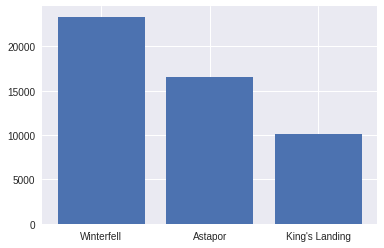

In [15]:
df.city.value_counts().index
counts = df.city.value_counts()
plt.bar(counts.index, counts.values)

<BarContainer object of 11 artists>

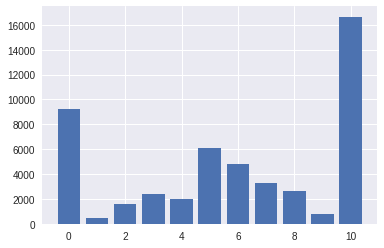

In [25]:
# weekday_pct has a lot of zeros and a lot of 100%
counts = (df.weekday_pct // 10).value_counts()
plt.bar(counts.index, counts.values)

<BarContainer object of 2 artists>

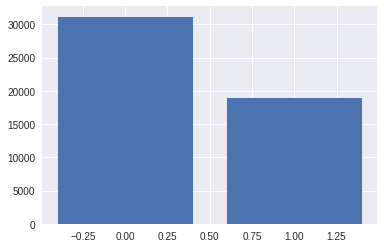

In [24]:
counts = df.ultimate_black_user.value_counts()
plt.bar(counts.index, counts.values)

### Feature Engineering and Reduction in Collinearity

In [40]:
#df['one_plus_black'] = (df.ultimate_black_user + 1) / 2

# List of column, description pairs to use in creating features
#numerics = [('avg_dist', 'dist'), ('avg_rating_by_driver', 'by'), ('avg_rating_of_driver', 'of'), ('avg_surge', 'surge'),
            #('surge_pct', 'surge_pct'), ('trips_in_first_30_days', 'trips'), ('one_plus_black', 'black'),
            #('weekday_pct', 'weekday')]

# Create composite features by multiplying numerics
#for col0, desc0 in numerics:
    #for col1, desc1 in numerics:
        #composite_descriptions = [(desc0 + '_' + desc1), (desc1 + '_' + desc0)]
        #if composite_descriptions[0] not in df.columns and composite_descriptions[1] not in df.columns:
            #df[composite_descriptions[0]] = df[col0] * df[col1]

In [29]:
def id_cols_to_drop(df, threshold):
    """
    Identifies columns to drop from a dataframe due to high correlation.
    Input: the dataframe of interest and the correlation coefficient threshold.
    Output: a list of the columns to drop.  Prints elapsed time to the screen because this takes a long time for a large
    dataframe.
    """

    time_0 = time.time()
        
    # Create correlation matrix
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    tt = time.time() - time_0
    print('Done. Took ' + str(tt) + 'seconds.')

    return(to_drop)

#id_cols_to_drop(data_chunk, 0.9)

In [41]:
#print(len(data_chunk.columns))
#datachunk = data_chunk.drop(['one_plus_black', 'dist_by', 'dist_of', 'dist_surge', 'by_by', 'by_surge', 'by_surge_pct',
                            #'by_trips', 'by_black', 'by_weekday', 'of_of', 'of_surge_pct', 'of_trips', 'of_black',
                            #'of_weekday', 'surge_surge', 'surge_surge_pct', 'surge_trips', 'surge_weekday',
                            #'surge_pct_surge_pct', 'surge_pct_black', 'trips_black', 'trips_weekday', 'black_black',
                            #'weekday_weekday'], axis='columns', inplace=True)
#print(len(data_chunk.columns))

### Model Testing

In [326]:
# RF, n_estimators=50, no scaling, outliers removed, n_features=14
#Best cv AUC: 0.85
#Best validation set score: 0.85
#Best parameters:  {'clf__max_depth': 10, 'clf__max_features': 'auto'}



# RF, no scaling, n=50, removing outliers: Train AUC:  0.9992193236609714, Test AUC:  0.7487661798685422


# Random Forest, no scaling, n=50, removing outliers
# len(data_chunk.columns) # 14, AUC:  0.7487661798685422, [[4207  746] [1064 1960]], accuracy 0.7753541431615896
# Then predicting on X_train, y_train: AUC 0.9482750402396632 (yeah right)

# With Random Forests
# len(data_chunk.columns) # 14, accuracy 0.7791250000000001, AUC:  0.7533500091142932, [[4316  774] [ 993 1917]] 
# len(data_chunk.columns) # 51, accuracy 0.771375 , AUC:  0.7439481092905029, [[4299  791] [1038 1872]]
#len(data_chunk.columns) # 26, accuracy 0.78 , AUC:  0.7532281476380477, [[4334  756] [1004 1906]]

# With pulling outliers:
#len(data_chunk.columns) # 14, accuracy 0.7729722953491287, AUC:  0.7486008359531983, [[4207  746] [1065 1959]]

# With pulling outliers and n_estimators = 5000:
# len(data_chunk.columns) # 14, accuracy 0.7796163971417827, AUC:  0.7562049535474732, [[4225  728] [1030 1994]]
# Then predicting on X_train, y_train: AUC 0.5411017630504311

# With SVC
#len(data_chunk.columns) # 26, accuracy 0.7362500000000001, AUC:  0.6867619954225994, [[4420  670] [1440 1470]]
#len(data_chunk.columns) # 14, accuracy 0.733625, AUC:  0.6834481059148387,  [[4416  674] [1457 1453]]
#len(data_chunk.columns) # 51, accuracy 0.7641249999999999, AUC:  0.7298614627427947, [[4355  735] [1152 1758]]

# With Logistic Regression
#len(data_chunk.columns) # 14, accuracy 0.733625, AUC:  0.6860237376703866, [[4381  709] [1422 1488]]
#len(data_chunk.columns) # 26, accuracy 0.737625, AUC:  0.690565356233839, [[4394  696] [1403 1507]]
#len(data_chunk.columns) # 51, accuracy 0.765625, AUC:  0.7319969078916276, [[4354  736] [1139 1771]]

14